# Widgets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datascience import * 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.optimize import curve_fit
import math
from math import *
import seaborn as sns
import itertools
%matplotlib inline

## Import Data

In [19]:
macroeconomics = pd.read_csv("macro.csv")
macroeconomics.head()

,DATE,UNRATE_lin,CPILFESL_pc1,NROU,DFF_lin,CPIAUCSL_pc1,GDPC1_lin,GDPPOT
0,1958/1/1,6.300000,2.79720,5.414240,1.869778,3.45614,2908.281,3010.305042
1,1958/4/1,7.366667,2.42775,5.418266,0.936923,3.27225,2927.395,3037.248201
2,1958/7/1,7.333333,2.06659,5.422658,1.318913,2.29980,2995.112,3064.719006
3,1958/10/1,6.366667,1.82232,5.427429,2.163370,1.91315,3065.141,3093.608068
4,1959/1/1,5.833333,1.81406,5.432577,2.577000,0.89317,3123.978,3122.886378


## Phillips Curve
Phillips Curve describes a negative relationship between inflation and unemployment. 

$$ \pi = - f(u)$$

where $\pi$ is the inflation rate, $u$ is the unemployment rate. 

**Let's first create a dataframe with relevant data, i.e. inflation rate and unemployment rate.**

In [3]:
phillips_curve = macroeconomics[["DATE", "UNRATE_lin", "CPILFESL_pc1", "NROU"]].copy()
phillips_curve["decade"] = phillips_curve["DATE"].apply(lambda date: int(date[:4]) // 10 * 10)
phillips_curve.set_index("DATE", inplace=True)
phillips_curve = phillips_curve.apply(pd.to_numeric)
phillips_curve.head()

,UNRATE_lin,CPILFESL_pc1,NROU,decade
DATE,,,,
1958/1/1,6.300000,2.79720,5.414240,1950
1958/4/1,7.366667,2.42775,5.418266,1950
1958/7/1,7.333333,2.06659,5.422658,1950
1958/10/1,6.366667,1.82232,5.427429,1950
1959/1/1,5.833333,1.81406,5.432577,1950


Friendly note: you should not use this piece of code for your lab, because the dataframe is slightly different!

### Empirical Relationship

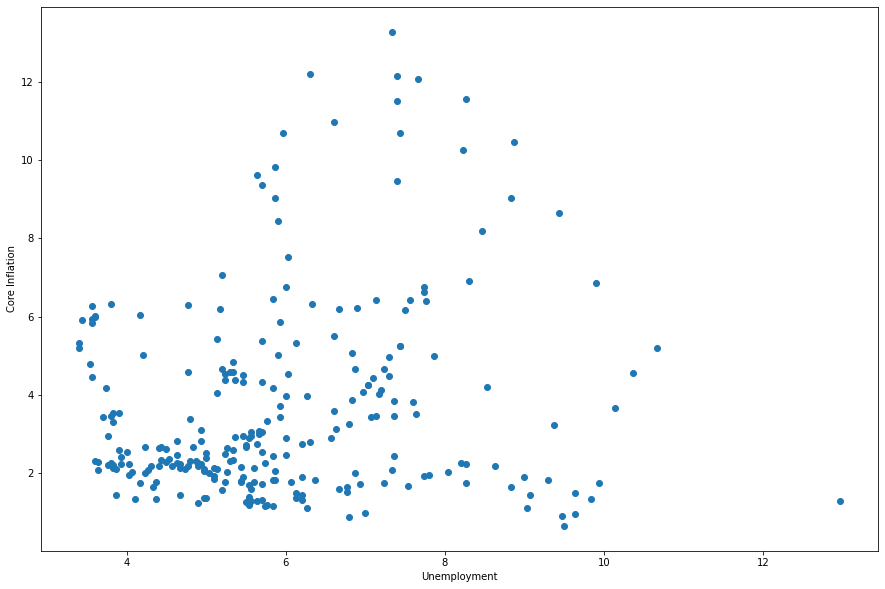

In [4]:
plt.figure(figsize=(15, 10))
plt.scatter(x=phillips_curve["UNRATE_lin"], y=phillips_curve["CPILFESL_pc1"])
plt.xlabel("Unemployment")
plt.ylabel("Core Inflation")
plt.show()

**Now we will try a fit a curve to the empirical data of unemployment and core inflation.** 

In [5]:
unique_vals = pd.DataFrame([[k,v.values] for k,v in phillips_curve.groupby('UNRATE_lin').groups.items()], 
                      columns=['UNRATE_lin','indices'])
unique_vals["indices"] = unique_vals["indices"].apply(lambda item: item[0])
unique_vals["CPILFESL_pc1"] = unique_vals["indices"].apply(lambda item: phillips_curve.loc[item, "CPILFESL_pc1"])
unique_vals["NROU"] = unique_vals["indices"].apply(lambda item: phillips_curve.loc[item, "NROU"])
unique_vals["decade"] = unique_vals["indices"].apply(lambda item: phillips_curve.loc[item, "decade"])
unique_vals.set_index("indices", inplace=True)
unique_vals.head()

,UNRATE_lin,CPILFESL_pc1,NROU,decade
indices,,,,
1968/10/1,3.400000,5.20341,5.826905,1960
1969/4/1,3.433333,5.92044,5.851210,1960
1968/7/1,3.533333,4.78011,5.815176,1960
1968/4/1,3.566667,4.44444,5.803658,1960
2019/10/1,3.600000,2.30326,4.524682,2010


In [6]:
def aesthetic_pc(x, a):
    return a / x

In [7]:
popt, _ = curve_fit(aesthetic_pc, unique_vals["UNRATE_lin"], unique_vals["CPILFESL_pc1"])

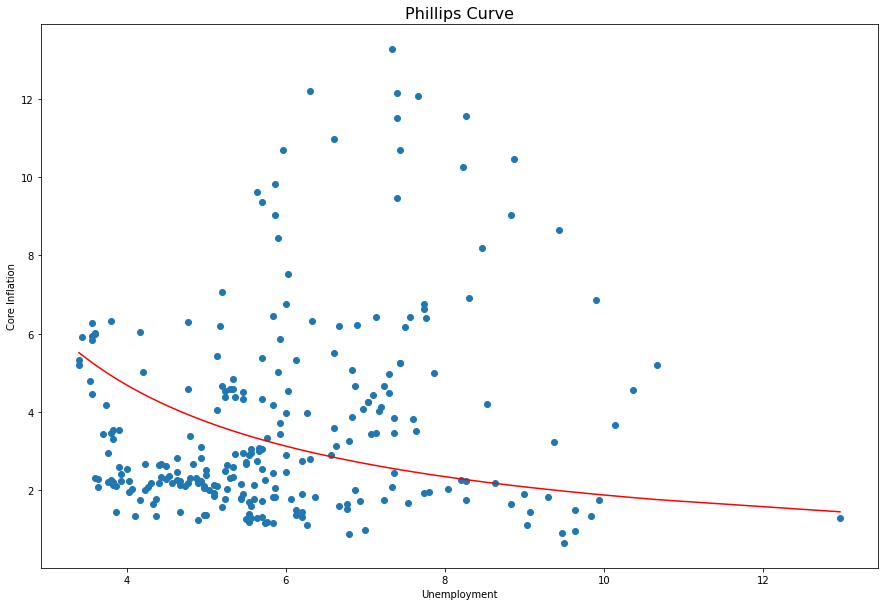

In [8]:
plt.figure(figsize=(15, 10))
plt.plot(unique_vals["UNRATE_lin"], aesthetic_pc(unique_vals["UNRATE_lin"], *popt), color="red")
plt.scatter(x=phillips_curve["UNRATE_lin"], y=phillips_curve["CPILFESL_pc1"])
plt.xlabel("Unemployment")
plt.ylabel("Core Inflation")
plt.title("Phillips Curve", fontsize=16)
plt.show()

### Empirical Relationship Overtime
How does the empirical Phillips Curve change over time?

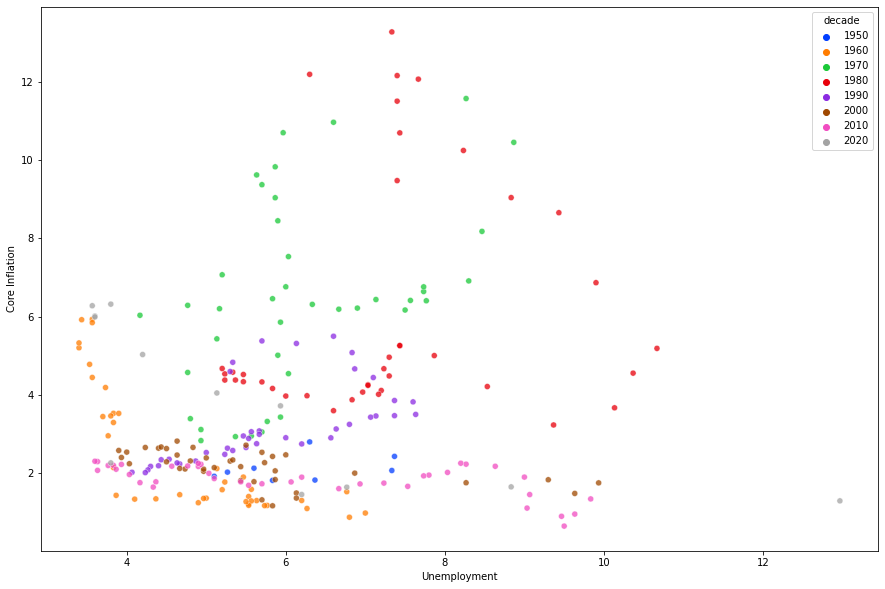

In [9]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x="UNRATE_lin", y="CPILFESL_pc1", data=phillips_curve, 
                hue="decade", palette="bright", alpha=0.75)
plt.xlabel("Unemployment")
plt.ylabel("Core Inflation")
plt.show()

To show this more clearly, try toggling the widgets!

In [10]:
def plot_subset(start, length):
    start_str = str(start) + "-01-01"
    end_str = str(start + length) + "-01-01"
    
    subset = phillips_curve[(phillips_curve.index >= start_str) & (phillips_curve.index <= end_str)]
    
    plt.figure(figsize=(12, 8))
    plt.scatter(subset["UNRATE_lin"], subset["CPILFESL_pc1"])
    plt.xlim(3, 10)
    plt.ylim(0, 12)
    plt.xlabel("Unemployment Rate", fontsize=16)
    plt.ylabel("Inflation Rate", fontsize=16)
    plt.title(f"Time Period: {start} - {start + length}", fontsize=16)

l = widgets.RadioButtons(
    options=[5, 10, 20],
    value=5,
    description='Length:',
    disabled=False
)
s = widgets.IntSlider(min=1960, max=2020-l.value, step=2)

interact(plot_subset, start=s, length=l);

interactive(children=(IntSlider(value=1960, description='start', max=2015, min=1960, step=2), RadioButtons(des…

<div class="alert alert-info">
<b> What do you notice about the relationship between unemployment and inflation over time?
</div>

---

## Taylor Rule

The Taylor Rule was first proposed in 1993 by the American economist John B. Taylor. It’s called a “rule” because it serves as a guide to monetary policy for how to set interest rates based on the inflation gap and output gap at a given time. The equation is as follows  

$$
r_{\text{predicted}} = r_{\text{target}} + \pi + \alpha \left ( \pi - \pi_{\text{target}} \right ) + \beta \left ( \dfrac{Y - Y^*}{Y^*} \right )
$$

where $r$ is the interest rate, $\pi$ is the inflation rate, and $Y$ is the economic output. $\alpha$ and $\beta$ are two parameters we can change to make the predictions from Taylor Rule more accurate. In the "classical" Taylor Rule, we set $\alpha$ and $\beta$ to be both $0.5$. This is what we will do next. 

In [11]:
def taylor_rule(interest_rate_target, inflation, inflation_target, output, potential_output, alpha=0.5, beta=0.5):
    return interest_rate_target + inflation + alpha * (inflation - inflation_target) + \
            beta * ((output - potential_output) / potential_output) * 100

In [12]:
def taylor_rule_plotter(arr, ffr_arr=None, label=None):
    plt.figure(figsize=(17, 9))
    if ffr_arr is not None:
        plt.plot(ffr_arr, label="FFR")
        plt.xticks(np.arange(0, ffr_arr.shape[0]), rotation = 45)
    else:
        plt.plot(macroeconomics["DATE"], macroeconomics["DFF_lin"], label="FFR")
        plt.xticks(np.arange(0, macroeconomics.shape[0], 20), rotation = 45)
    plt.plot(arr, label=label)
    plt.legend()
    plt.grid()
    plt.axhline(color="black", linestyle="-.")
    plt.title("Empirical Evidence of the Taylor Rule", fontsize=16)
    plt.show();

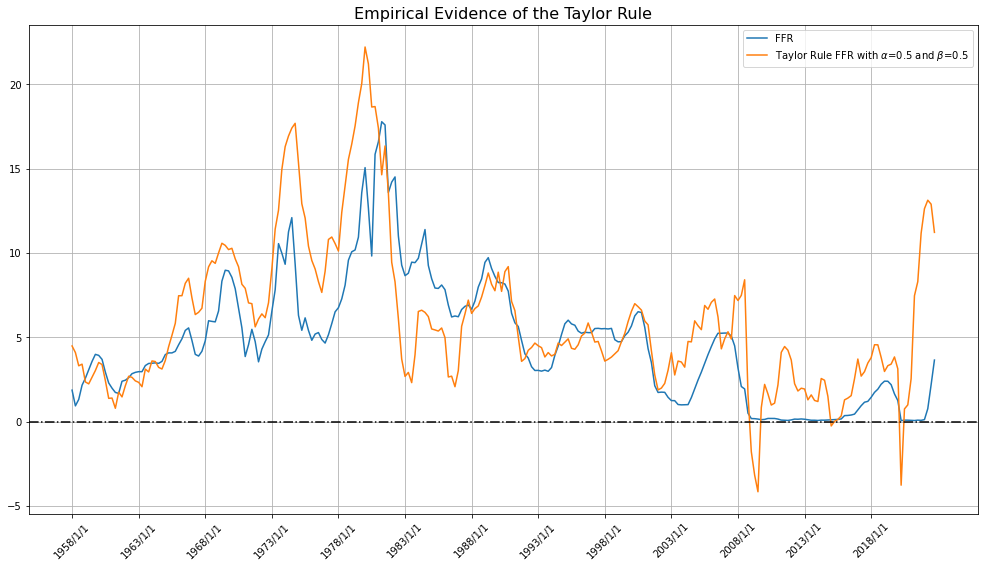

In [13]:
# "CPIAUCSL_pc1" is the inflation rate, "GDPC1_lin" is GDP
taylor_rule_preds = taylor_rule(2, macroeconomics.loc[:, "CPIAUCSL_pc1"], 2, 
                                macroeconomics.loc[:, "GDPC1_lin"], macroeconomics.loc[:, "GDPPOT"])

taylor_rule_plotter(taylor_rule_preds, label=r"Taylor Rule FFR with $\alpha$=0.5 and $\beta$=0.5")

As we can see, the predictions from the Taylor Rule generally follow very closely with the actual Federal Funds rate. 

### Best Parameters for Taylor Rule

Now we will find what the set of $\alpha$ and $\beta$ that can best approximate the actual Federal Funds Rate using the Taylor Rule.  
Again recall the Taylor Rule: 
$$
r_{\text{predicted}} = r_{\text{target}} + \pi + \alpha \left ( \pi - \pi_{\text{target}} \right ) + \beta \left ( \dfrac{Y - Y^*}{Y^*} \right )
$$

In [14]:
def taylor_rmse(alpha, beta):
    taylor_interest_rate = np.array(taylor_rule(2, macroeconomics["CPIAUCSL_pc1"], 2, 
                                                macroeconomics["GDPC1_lin"], macroeconomics["GDPPOT"], 
                                                alpha = alpha, beta = beta))
    actual_interest_rate = np.array(macroeconomics["DFF_lin"])
    return np.mean(((taylor_interest_rate - actual_interest_rate) ** 2))

In [15]:
def taylor_widget(alpha, beta):
    rmse = taylor_rmse(alpha, beta)
    print(f"RMSE: {rmse}")
    taylor_rule_preds = taylor_rule(2, macroeconomics["CPIAUCSL_pc1"], 2, 
                                macroeconomics["GDPC1_lin"], macroeconomics["GDPPOT"], 
                                    alpha=alpha, beta=beta)
    taylor_rule_plotter(taylor_rule_preds, 
                        label=rf"Taylor Rule FFR with $\alpha$={alpha} and $\beta$={beta}");

Try toggling the sliders, and see if you can find a pair of $\alpha$ and $\beta$ that minimizes the RMSE!

In [16]:
alpha_widget = widgets.FloatSlider(min=-1, max=2, step=0.1, value=0.5)
beta_widget = widgets.FloatSlider(min=-1, max=2, step=0.1, value=0.5)
interact(taylor_widget, alpha=alpha_widget, beta=beta_widget);

interactive(children=(FloatSlider(value=0.5, description='alpha', max=2.0, min=-1.0), FloatSlider(value=0.5, d…

### Optimizing for $\alpha$, $\beta$
This time we will let the algorithm to optimize $\alpha$ and $\beta$ for us. Compare the results and see what you can find! 

In [17]:
alpha, beta = minimize(taylor_rmse)
print(f"RMSE using optimized parameters: {taylor_rmse(alpha, beta)}")
print(f"alpha: {alpha}, beta: {beta}")

RMSE using optimized parameters: 6.6033690944415415
alpha: -0.1755269695548164, beta: 0.2794608048942147


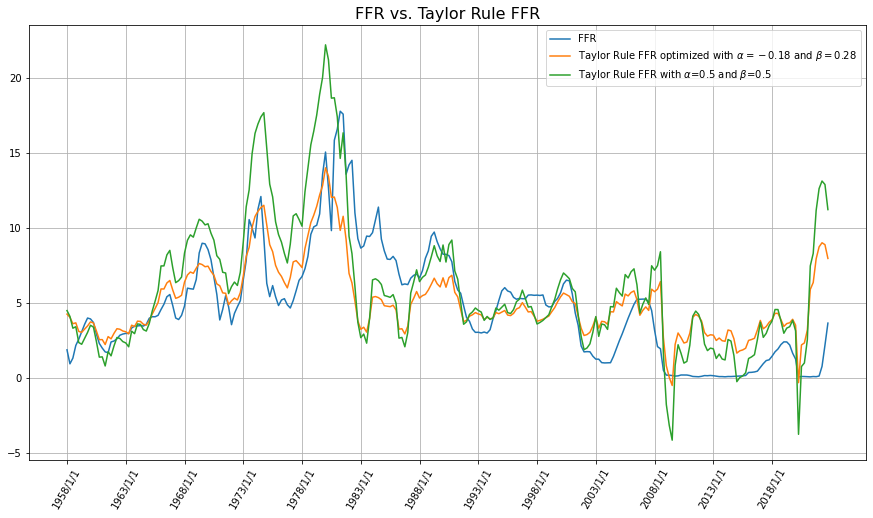

In [18]:
taylor_rule_preds = taylor_rule(2, macroeconomics.loc[:, "CPIAUCSL_pc1"], 2, 
                                macroeconomics.loc[:, "GDPC1_lin"], macroeconomics.loc[:, "GDPPOT"], 
                                alpha=alpha, beta=beta)
taylor_rule_preds_basic = taylor_rule(2, macroeconomics.loc[:, "CPIAUCSL_pc1"], 2, 
                                      macroeconomics.loc[:, "GDPC1_lin"], macroeconomics.loc[:, "GDPPOT"], 
                                      alpha=0.5, beta=0.5)

plt.figure(figsize=(15, 8))
plt.plot(macroeconomics["DATE"], macroeconomics["DFF_lin"], label="FFR")
plt.plot(taylor_rule_preds, label=fr"Taylor Rule FFR optimized with $\alpha={np.round(alpha, 2)}$ and $\beta={np.round(beta, 2)}$")
plt.plot(taylor_rule_preds_basic, label=r"Taylor Rule FFR with $\alpha$=0.5 and $\beta$=0.5")
plt.xticks(rotation=45)
plt.xticks(np.arange(0, macroeconomics.shape[0], 20), rotation=60)
plt.legend()
plt.grid()
plt.title("FFR vs. Taylor Rule FFR", fontsize=16)
plt.show();